In [ ]:
import pandas as pd
import numpy as np
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Preprocessing functions
def preprocess(text):
    text = text.lower()
    text = text.strip()
    text = re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\[[0-9]*\]', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

import nltk
nltk.download('stopwords')

def stopword(string):
    return ' '.join([i for i in string.split() if i not in stopwords.words('english')])

def stemming(string):
    snow = SnowballStemmer('english')
    return ' '.join([snow.stem(i) for i in word_tokenize(string)])

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatizer(string):
    wl = WordNetLemmatizer()
    word_pos_tags = nltk.pos_tag(word_tokenize(string))
    return ' '.join([wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for tag in word_pos_tags])

def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

# Load and preprocess data
df_train = pd.read_csv('SPEND_UNSPC.csv')
df_train['clean_text'] = df_train['ITEM_DESC'].apply(lambda x: finalpreprocess(x))
df_train = df_train.drop(columns=['ITEM_DESC'])

# Tokenization and padding
X = df_train['clean_text'].values
y = df_train['SEGMENT'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y_categorical, test_size=0.2, shuffle=True)

# Tokenizer and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

max_length = max(max(len(seq) for seq in X_train_sequences), max(len(seq) for seq in X_val_sequences))
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length)
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length)

# Build RNN model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
model.add(SimpleRNN(64, return_sequences=False))
model.add(Dense(len(le.classes_), activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_data=(X_val_padded, y_val))

# Evaluate model
y_val_pred = model.predict(X_val_padded)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val, axis=1)

print("Classification Report:\n", classification_report(y_val_true, y_val_pred_classes))
print("Accuracy Score:", accuracy_score(y_val_true, y_val_pred_classes))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-2-2dfb12030868>:68: DtypeWarning: Columns (10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('SPEND_UNSPC.csv')


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1335/1335 ━━━━━━━━━━━━━━━━━━━━ 37s 26ms/step - accuracy: 0.5508 - loss: 1.5094 - val_accuracy: 0.7434 - val_loss: 0.9156
Epoch 2/5
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accuracy: 0.7768 - loss: 0.8167 - val_accuracy: 0.7820 - val_loss: 0.8183
Epoch 3/5
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 42s 26ms/step - accuracy: 0.7181 - loss: 0.9282 - val_accuracy: 0.8439 - val_loss: 0.5720
Epoch 4/5
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.8231 - loss: 0.6096 - val_accuracy: 0.8369 - val_loss: 0.5826
Epoch 5/5
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.8450 - loss: 0.5371 - val_accuracy: 0.8321 - val_loss: 0.6337
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Classification Report:
               precision    recall  f1-score   support

           1       0.33      0.05      0.08        22
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         3
           5       0.62      0.19      0.29        52
           6       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.save('initial_rnn_model.keras')

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential, load_model

def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=hp.Int('embedding_dim', min_value=32, max_value=128, step=32), input_length=max_length))
    rnn_layer = hp.Choice('rnn_layer', ['SimpleRNN', 'LSTM', 'GRU'])

    if rnn_layer == 'SimpleRNN':
        model.add(SimpleRNN(units=hp.Int('units', min_value=32, max_value=128, step=32), return_sequences=False))
    elif rnn_layer == 'LSTM':
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), return_sequences=False))
    elif rnn_layer == 'GRU':
        model.add(GRU(units=hp.Int('units', min_value=32, max_value=128, step=32), return_sequences=False))

    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(len(le.classes_), activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Instantiate the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='rnn_tuning'
)

# Search for the best hyperparameters
tuner.search(X_train_padded, y_train, epochs=10, validation_data=(X_val_padded, y_val))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

best_model.save('best_rnn_model.keras')

# Evaluate the best model
best_loaded_model = load_model('best_rnn_model.keras')
y_val_pred = best_loaded_model.predict(X_val_padded)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val, axis=1)

print("Classification Report:\n", classification_report(y_val_true, y_val_pred_classes))
print("Accuracy Score:", accuracy_score(y_val_true, y_val_pred_classes))


Trial 30 Complete [00h 06m 10s]
val_accuracy: 0.9411985278129578

Best val_accuracy So Far: 0.9867977499961853
Total elapsed time: 02h 44m 07s


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 48, 96)              │         480,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 96)                  │          55,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 35)                  │           3,395 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 539,267 (2.06 MB)

 Trainable params: 539,267 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'best_rnn_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

best_model.save('best_rnn_model.keras')

# Evaluate the best model
best_loaded_model = load_model('best_rnn_model.keras')
y_val_pred = best_loaded_model.predict(X_val_padded)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val, axis=1)

print("Classification Report:\n", classification_report(y_val_true, y_val_pred_classes))
print("Accuracy Score:", accuracy_score(y_val_true, y_val_pred_classes))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 48, 96)              │         480,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 96)                  │          55,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 35)                  │           3,395 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 539,267 (2.06 MB)

 Trainable params: 539,267 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Classification Report:
               precision    recall  f1-score   support

           1       0.88      1.00      0.94        22
           3       1.00      1.00      1.00         1
           4       1.00      0.33      0.50         3
           5       0.98      0.94      0.96        52
           6       0.00      0.00      0.00         1
           8       0.99      0.98      0.99       342
           9       0.84      0.93      0.88        45
          10       0.74      0.64      0.68        22
          11       0.97      0.98      0.98       307
          12       0.91      0.92      0.92       118
          13       0.95      0.94      0.95       105
          14       0.99      1.00      0.99      4321
          15       1.00      0.96      0.98       223
          16       1.00      0.99      0.99      1273
          17       0.99      0.99      0.99      2777
          18       0.98      0.99      0.98       734
          19   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_val_pred_segments = le.inverse_transform(y_val_pred_classes)
y_val_true_segments = le.inverse_transform(y_val_true)

In [ ]:
df_test = pd.DataFrame({
    'clean_text': X_val,
    'Actual Segment': y_val_true_segments,
    'Predicted Segment': y_val_pred_segments,
    'Prediction Probability': np.max(y_val_pred, axis=1)
})

# Reset index and save to CSV
final = df_test.reset_index(drop=True)
final.to_csv('Output.csv', index=False)

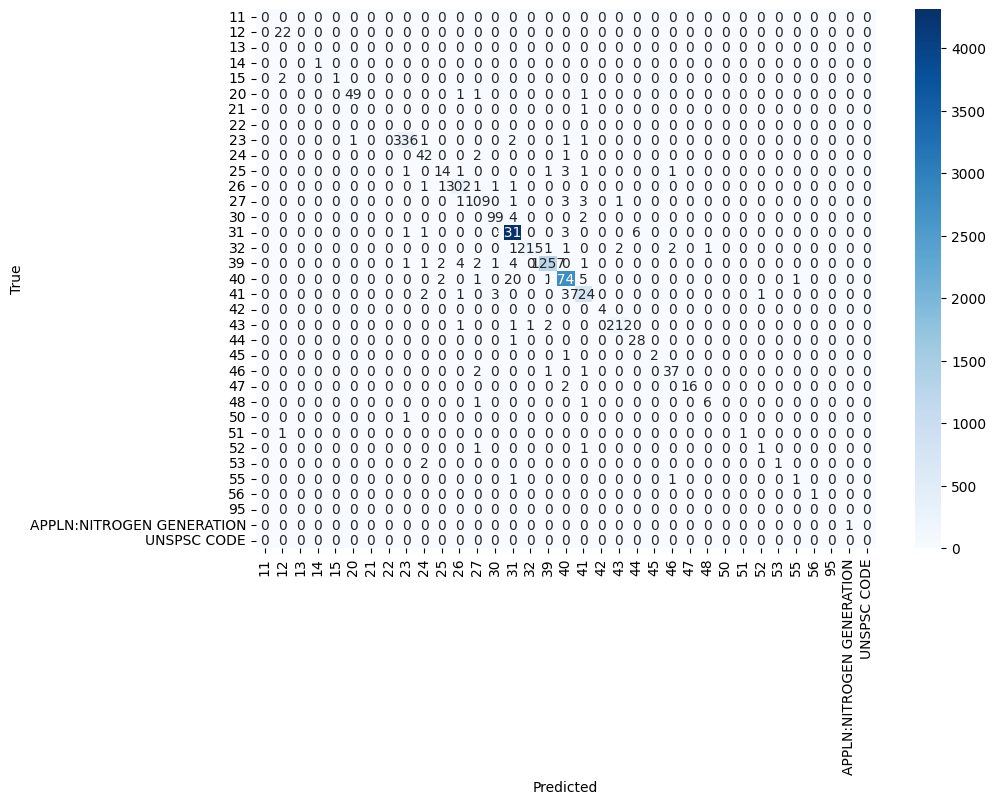

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val_true_segments, y_val_pred_segments, labels=le.classes_)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


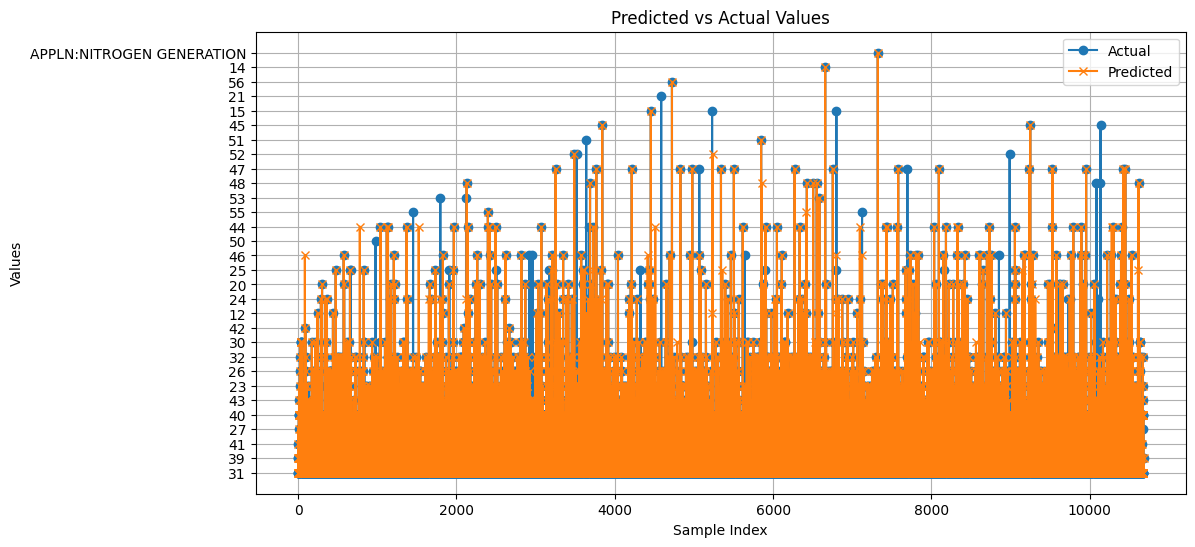

In [ ]:
import matplotlib.pyplot as plt
y_true = np.array(y_val_true_segments)
y_pred = np.array(y_val_pred_segments)

x_range = np.arange(len(y_true))

plt.figure(figsize=(12, 6))
plt.plot(x_range, y_true, label='Actual', marker='o')
plt.plot(x_range, y_pred, label='Predicted', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

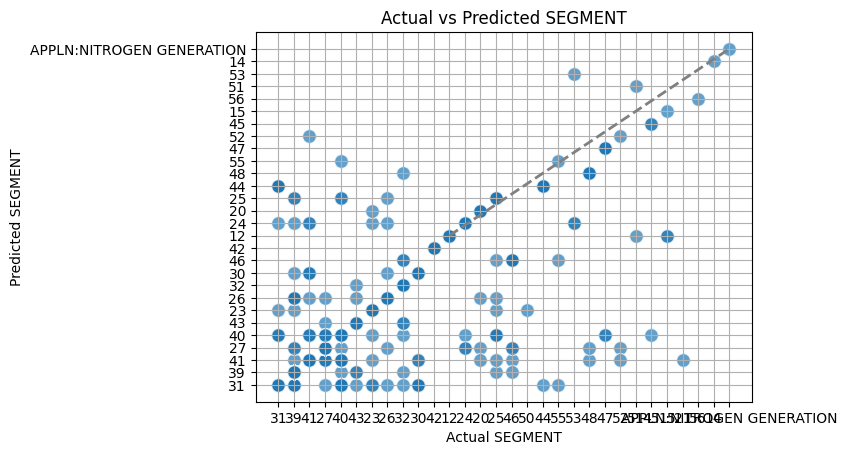

In [ ]:
plt.scatter(y_true, y_pred, alpha=0.7, edgecolors='w', s=100)

# Set labels and title
plt.xlabel("Actual SEGMENT")
plt.ylabel("Predicted SEGMENT")
plt.title("Actual vs Predicted SEGMENT")

# Add a diagonal line for perfect prediction
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='gray', linestyle='--', linewidth=2)

# Show the plot
plt.grid(True)
plt.show()

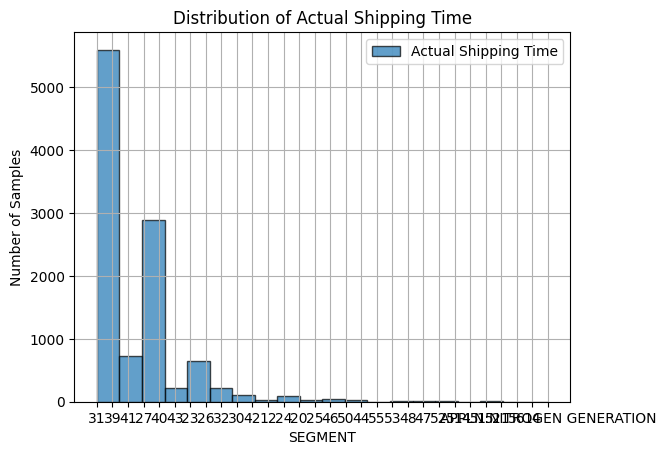

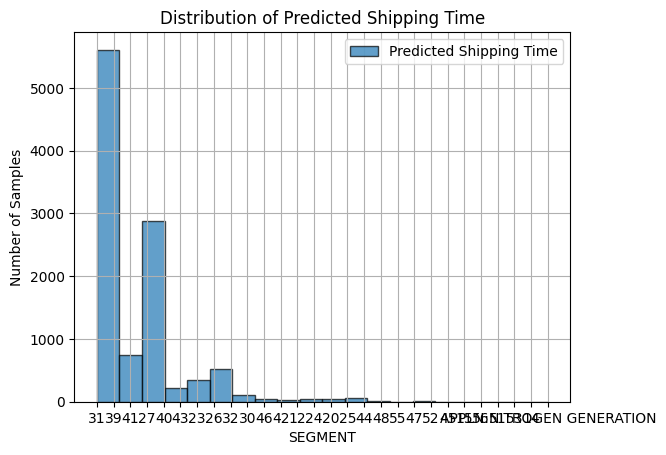

In [ ]:
# Plot actual values distribution (histogram)
plt.hist(y_true, bins=20, edgecolor='black', alpha=0.7, label='Actual Shipping Time')
plt.xlabel("SEGMENT")
plt.ylabel("Number of Samples")
plt.title("Distribution of Actual Shipping Time")
plt.legend()
plt.grid(True)
plt.show()

# Plot predicted values distribution (histogram)
plt.hist(y_pred, bins=20, edgecolor='black', alpha=0.7, label='Predicted Shipping Time')
plt.xlabel("SEGMENT")
plt.ylabel("Number of Samples")
plt.title("Distribution of Predicted Shipping Time")
plt.legend()
plt.grid(True)
plt.show()